## Random Walk

The agent is in an horizontal world and can move left or right with probability .5.
The reward is 0 for all transitions except for the transition to the right terminal state.

We eventually introduce randomness in the transitions by giving probability .1 to stay in the current state, probability 0.1 to move 2 steps at once and probability .8 to move to the next state.

In [1]:
from gym import Env
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import itertools
import copy
import sys

def move_left(current_index):
    return current_index-1
    
def move_right(current_index):
    return current_index+1

def compute_rmse(V, V_mdp):
    squared_err=0
    for v,v_mdp in zip(V,V_mdp):
        squared_err+=(v-v_mdp)**2
    return np.sqrt(squared_err/len(V))


2

In [419]:
class RandomWalkEnv(Env):
    def __init__(self, n_states):
        self.actions = [move_left, move_right]
        self.n_actions = len(self.actions)
        self.n_states = n_states        
        self.R = self.init_R()
        self.P = self.init_P()
        self.state = self.n_states//2
        
    def step(self,action):
        done=False
        a = self.actions.index(action)
        s = self.state
        reward = self.R[a,s]
        next_state = np.random.choice(range(self.n_states), p=self.P[a,s])
        
        if next_state == 0 or next_state == self.n_states-1:
            done = True
            
        self.state = next_state
        return next_state, reward, done, None
    
    def reset(self):
        self.state = np.random.choice(np.arange(1,self.n_states-1))
        return self.state
    
    
    def init_P(self):
        ## * transition matrix * ##
        P = np.zeros((self.n_actions,self.n_states,self.n_states))
        for i in range(1,self.n_states-1):
            # move left :
            if i-1>=0: P[0,i,i-1] = 1.
            # move right
            if i+1<self.n_states: P[1,i,i+1] = 1.
        # Terminal states
        P[:,0,0]=1.
        P[:,self.n_states-1,self.n_states-1]=1.
        return P
    
    def init_R(self):
        ## * reward matrix * ##
        R = -1*np.ones((self.n_actions, self.n_states))
        R[0,1] = -max(100, 2*self.n_states) #np.iinfo(np.int).min
        R[1,self.n_states-2] = 10
        R[:,0] = 0.
        R[:,self.n_states-1] = 0.
        return R

In [420]:
def make_random_policy(env): 
    n_states = env.n_states
    n_actions = env.n_actions
    random_policy = np.ones((n_actions, n_states))/n_actions
    # Terminal states
    random_policy[:,0]=0.
    random_policy[:,n_states-1]=0.
    return random_policy

In [421]:
def markov_reward_process(env, policy):
    P_ = np.zeros_like(env.P[0])
    R_ = np.sum(env.R*policy,axis=0)
    for s in range(env.n_states):
        P_[s,:] = policy[:,s] @ env.P[:,s,:]
    return R_, P_

def mdp_policy_evaluation(env, policy, epsilon= 10**-4, n_iter_max=2000, gamma=1, verbose=False):
    R_, P_ = markov_reward_process(env, policy)
    V_k = np.zeros(env.n_states)
    delta = epsilon+1
    n_iter=1
    while delta>epsilon and n_iter<=n_iter_max:
        V_k_1 = R_ + gamma * P_ @ V_k
        delta = max(epsilon, np.max(np.abs(V_k_1-V_k)))
        V_k = V_k_1
        n_iter+=1
    if verbose:
        if delta>epsilon:
            print("Warning : Policy evaluation did not converge after %d steps"%(n_iter-1))
            print("delta : {}".format(delta))
        else:
            print("Policy evaluation did converge after %d steps"%(n_iter-1))
    return V_k_1

def greedy(env,v,gamma):
    eps = np.finfo(np.float64).resolution
    new_policy = np.zeros_like(env.R)
    Q = np.zeros_like(env.R)
    
    for s in range(env.n_states):
        for a in range(env.n_actions):           
            Q[a,s] = env.R[a,s] + gamma * np.sum(env.P[a,s,:] * v)
            
    for s in range(1,env.n_states-1):
        best_actions = np.where(np.abs(Q[:,s]-np.max(Q[:,s]))<=eps)[0]
        n_best = len(best_actions)
        for a in best_actions:
            new_policy[a,s]= 1./n_best
    return new_policy,Q

def mdp_policy_iteration(env, old_policy=None, epsilon= 10**-7, n_iter_max=200, gamma=1, verbose=False):
    
    if old_policy is None:
        old_policy = make_random_policy(env)

    policy_stable = False
    n_iter=0
    while not policy_stable:
        n_iter+=1
        new_v = mdp_policy_evaluation(env, old_policy, epsilon=epsilon, n_iter_max=n_iter_max, gamma=gamma)
        new_policy,Q = greedy(env, new_v, gamma)
        policy_stable = np.array_equal(old_policy, new_policy)
        old_policy = new_policy
    if verbose:
        print("Policy iteration did converge after %d steps"%(n_iter))
    return new_policy
        
def mdp_value_iteration(env, epsilon= 10**-7, n_iter_max=200, gamma=1, verbose=False):
    V_k = np.zeros(env.n_states)
    delta = epsilon+1
    n_iter=1
    while delta>epsilon and n_iter<=n_iter_max:
        
        V_k_1 = np.max(env.R + gamma * env.P @ V_k,axis=0)
        delta = max(epsilon, np.max(np.abs(V_k_1-V_k)))
        V_k = V_k_1
        n_iter+=1
    return V_k_1
        

In [422]:
env = RandomWalkEnv(7)
random_policy = make_random_policy(env)

In [423]:
value = mdp_policy_evaluation(env,random_policy)

In [424]:
value

array([  0.        , -85.66647433, -70.33303918, -52.99961534,
       -33.66637251, -12.333141  ,   0.        ])

In [425]:
optimal_policy = mdp_policy_iteration(env)

In [426]:
optimal_policy

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0.]])

In [427]:
optimal_value = mdp_value_iteration(env)

In [428]:
optimal_value

array([ 0.,  6.,  7.,  8.,  9., 10.,  0.])

## Monte Carlo Policy Evaluation

We now want to approximate the value function for a given policy by using samples of experience and update the value function at the end of each episode of experience. The idea is for each state to average all its values from each episode in an iterative way using the iterative mean formula : $\mu_{k+1} = \mu_k + \frac{1}{k} (x_{k+1}-\mu_k)$. 
Then at the end of an episode, we can update the values of state $S_t$ :

- MC policy evaluation : 
$$ V(S_t)= V(S_t) + \frac{1}{N(S_t)}(G_t - V(S_t)) $$

    Where $N(S_t)$ is the number of time the state S_t has been visited.
    Note that in MC policy evaluation all the history is taken into acount. We can introduce a constant $\alpha$ instead of $\frac{1}{N(S_t)}$ to forget the oldest experience.
    

- $\alpha$-MC policy evaluation :
$$ V(S_t)= V(S_t) + \alpha(G_t - V(S_t)) $$

In both MC and $\alpha$-MC policy evaluation we need to compute, at each time step t, the full return :

$$G_t = R_{t+1} + \gamma R_{t+2}+\dots + \gamma^{T-1} R_T $$

In [492]:
def run_episode(env, policy):
    episode = []
    state = env.reset()
    for t in itertools.count():
        # pick an action
        action = np.random.choice(env.actions, p= policy[:,state])
        next_state, reward, done, _ = env.step(action)
        episode.append((state, reward))
        if done:
            break
        state = next_state
    return episode


def compute_return(episode, t, n=None, gamma=1):
    t = max(t,0)
    if n is None:
        n=len(episode)
    n = max(n,1)
    power = np.arange(t,n)
    rewards = np.array(episode)[:,1][t:t+n]
    G = np.dot(gamma**power , rewards)
    return G



In [493]:
def mc_policy_eval(env, policy, n_iter=200, gamma=1, alpha=None):
    if alpha is None:
        N = np.zeros(env.n_states)
    else:
        alpha = min(alpha,0.99)
    V = np.zeros(env.n_states)
    V_hist = []
    
    for e in range(n_iter):
        # start of episode
        episode = run_episode(env, policy)
        for t,(St,Rt_1) in enumerate(episode):
            # Compute Return from sthis state onwards
            Gt = compute_return(episode, t, gamma=gamma)
            # Update value
            if alpha is None:
                N[St] +=1
                V[St] += (1/(N[St]))*(Gt - V[St])
            else:
                V[St] += alpha*(Gt - V[St])
                  
        # end of episode
        V_hist.append(copy.copy(V))
    return V_hist




In [494]:
episode = run_episode(env, random_policy)
episode[-1]

(1, -100.0)

In [506]:
mdp_policy_evaluation(env, random_policy)

array([  0.        , -85.66647433, -70.33303918, -52.99961534,
       -33.66637251, -12.333141  ,   0.        ])

In [496]:
mc_policy_eval(env, random_policy,n_iter=100,alpha=0.1)[-1]

array([  0.        , -83.81440271, -73.37242298, -54.83973683,
       -30.29697215,   5.61917412,   0.        ])

In [495]:
mdp_policy_evaluation(env, optimal_policy)

array([ 0.,  6.,  7.,  8.,  9., 10.,  0.])

In [497]:
mc_policy_eval(env, optimal_policy,n_iter=100,alpha=0.1)[-1]

array([0.        , 5.46822371, 6.85807108, 7.99056785, 8.99823036,
       9.99973439, 0.        ])

## Temporal Difference policy evaluation

Temporal Difference use the same idea as MC but use intermediate estimated values of the return $G_t$ by bootstraping. This estimate is call TD-target : 
$$ td\_target = R_{t+1} + \gamma V(S_{t+1}) $$

- TD policy evaluation :
$$ V(S_t)= V(S_t) + \alpha(R_{t+1} + \gamma V(S_{t+1}) - V(S_t)) $$

TD backups allows to do online update and works even with non episodic experiences. Unlike MC updates we don't have to wait until the end of the episode to do updates.

In [526]:
def td_policy_eval(env, policy, n_iter=100, gamma=1., alpha=0.1):
    V = np.zeros(env.n_states)
    alpha = min(alpha,0.99)
    V_hist = []
    for e in range(n_iter):
        
        # start episode
        state = env.reset()
        for t in itertools.count():
            # pick an action
            action = np.random.choice(env.actions, p= policy[:, state])
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * V[next_state]
            V[state] += alpha*(td_target - V[state])
            if done:
                break
            
            state = next_state
        # end of episode    
        V_hist.append(copy.copy(V))
    return V_hist



In [527]:
mdp_policy_evaluation(env, random_policy)

array([  0.        , -85.66647433, -70.33303918, -52.99961534,
       -33.66637251, -12.333141  ,   0.        ])

In [528]:
td_policy_eval(env, random_policy,n_iter=200)[-1]

array([  0.        , -84.22204681, -61.30470809, -43.46602771,
       -21.58980021,  -3.97933053,   0.        ])

In [529]:
mdp_policy_evaluation(env, optimal_policy)

array([ 0.,  6.,  7.,  8.,  9., 10.,  0.])

In [530]:
td_policy_eval(env, optimal_policy,n_iter=200)[-1]

array([0.        , 5.3923125 , 6.96074833, 7.99880222, 8.99999415,
       9.99999999, 0.        ])

## TD$(n)$ and TD$(\lambda)$ policy evaluation

- TD$(n)$ :  
We can look n-step ahead to compute the estimation of the return :
$$G^{(n)}_t =  R_{t+1} + \gamma R_{t+1} + \gamma^2 V(S_{t+2}) + \dots + \gamma^{n} R_{t+n}$$
And to the update using this value :
$$ V(S_t)= V(S_t) + \alpha(G^{(n)}_t - V(S_t)) $$

- TD$(\lambda)$ :  
To avoid choosing the right n, we can average over all n by using a geometric mean (for efficient computing)
$$G^{\lambda}_t = (1-\lambda) \sum^{\infty}_{n=1}{\lambda^{n-1}}G^{(n)}_t$$
$$ V(S_t)= V(S_t) + \alpha(G^{\lambda}_t - V(S_t)) $$

- TD$(\lambda)$, MC and TD relationship :   
For $\lambda =1$, $G^{\lambda}_t = G_t$, this is MC.  
For $\lambda =0$, $G^{\lambda}_t = G^{(0)}_t$, this is TD(n=0).

## Experiments

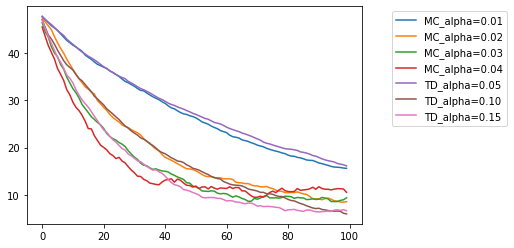

In [510]:
import matplotlib.pyplot as plt


mdp_values = mdp_policy_evaluation(env, random_policy)

f_err = lambda v : list(map(partial(compute_rmse,V_mdp=mdp_values),v))


mc_alphas = [.01,.02,.03,.04]
td_alphas = [.05,.1,.15]

err_mc_alpha = [[] for alpha in mc_alphas]
err_td_alpha = [[] for alpha in td_alphas]

nsamples = 50
n_iter = 100

for i, alpha in enumerate(mc_alphas):
    tmp = np.zeros((nsamples,n_iter))
    for k in range(nsamples):
        mc_values = mc_policy_eval(env, random_policy, n_iter=n_iter,gamma=1, alpha=alpha)
        tmp[k] = np.array(f_err(mc_values))
    err_mc_alpha[i] = np.average(tmp,axis=0)

for i, alpha in enumerate(td_alphas):
    tmp = np.zeros((nsamples,n_iter))
    for k in range(nsamples):
        td_values = td_policy_eval(env, random_policy, n_iter=n_iter,gamma=1, alpha=alpha)
        tmp[k] = np.array(f_err(td_values))
    err_td_alpha[i] = np.average(tmp,axis=0)

for i,alpha in enumerate(mc_alphas):
    plt.plot(err_mc_alpha[i],label="MC_alpha=%.2f"%alpha)
for i,alpha in enumerate(td_alphas):
    plt.plot(err_td_alpha[i],label="TD_alpha=%.2f"%alpha)
plt.legend(bbox_to_anchor=(1.45, 1),loc='upper right')
plt.show()

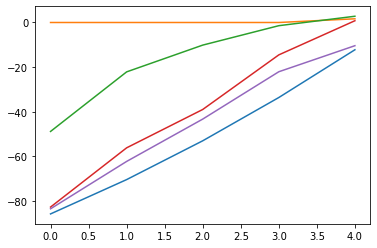

In [521]:
plt.plot(mdp_values[1:-1])
# plt.plot(mc_values[-1])
for i in [1,10,100,200]:
    plt.plot(td_policy_eval(env, random_policy, n_iter=i,gamma=1, alpha=.15)[-1][1:-1])
plt.show()